In [1]:
!pip install diffusers==0.19.2 transformers accelerate safetensors huggingface_hub
!git clone https://github.com/replicate/cog-sdxl cog_sdxl

fatal: destination path 'cog_sdxl' already exists and is not an empty directory.


### Part-1: Coherent Panorama

In [45]:
import torch
from torch import Tensor, Optional
from torch.nn import functional as F
from torch.nn.modules.utils import _pair
from huggingface_hub import hf_hub_download
import diffusers
from diffusers import DiffusionPipeline
from cog_sdxl.dataset_and_utils import TokenEmbeddingsHandler

# Define asymmetric convolution function for model customization
def asymmetricConv2DConvForward(self, input: Tensor, weight: Tensor, bias: Optional[Tensor]):
    """Performs asymmetric convolution with circular padding on the horizontal axis."""
    self.paddingX = (self._reversed_padding_repeated_twice[0], self._reversed_padding_repeated_twice[1], 0, 0)
    self.paddingY = (0, 0, self._reversed_padding_repeated_twice[2], self._reversed_padding_repeated_twice[3])
    working = F.pad(input, self.paddingX, mode='circular')  # Wrap elements around horizontally
    working = F.pad(working, self.paddingY, mode='constant')  # Extend edges vertically
    return F.conv2d(working, weight, bias, self.stride, _pair(0), self.dilation, self.groups)

# Load Stable Diffusion XL pipeline with optimizations
pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    torch_dtype=torch.float16,
    variant="fp16",
).to("cuda")

# Disable tiling for potential efficiency gains
pipe.vae.use_tiling = False

# Modify model architecture for asymmetric convolution and LoRA compatibility
targets = [pipe.vae, pipe.text_encoder, pipe.unet]  # Target modules for modification
conv_layers = []  # Collect convolution layers for modification
for target in targets:
    for module in target.modules():
        if isinstance(module, torch.nn.Conv2d):
            conv_layers.append(module)

for cl in conv_layers:
    if isinstance(cl, diffusers.models.lora.LoRACompatibleConv) and cl.lora_layer is None:
        cl.lora_layer = lambda *x: 0  # Initialize placeholder LoRA layer if needed

    cl._conv_forward = asymmetricConv2DConvForward.__get__(cl, torch.nn.Conv2d)  # Replace forward method

# Load LoRA weights for enhanced capabilities
pipe.load_lora_weights("jbilcke-hf/sdxl-panorama", weight_name="lora.safetensors")

# Prepare text encoders and tokenizers for embedding handling
text_encoders = [pipe.text_encoder, pipe.text_encoder_2]
tokenizers = [pipe.tokenizer, pipe.tokenizer_2]

# Download and load token embeddings
embedding_path = hf_hub_download(
    repo_id="jbilcke-hf/sdxl-panorama", filename="embeddings.pti", repo_type="model"
)
embhandler = TokenEmbeddingsHandler(text_encoders, tokenizers)
embhandler.load_embeddings(embedding_path)

# Generate image with specified dimensions and prompt
prompt = "animated, tropical forest in anime world"
images = pipe(
    prompt,
    cross_attention_kwargs={"scale": 0.8},
    height=512,  # Set desired height
    width=1024,  # Set desired width
).images

# Access the generated image
final_image = images[0]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

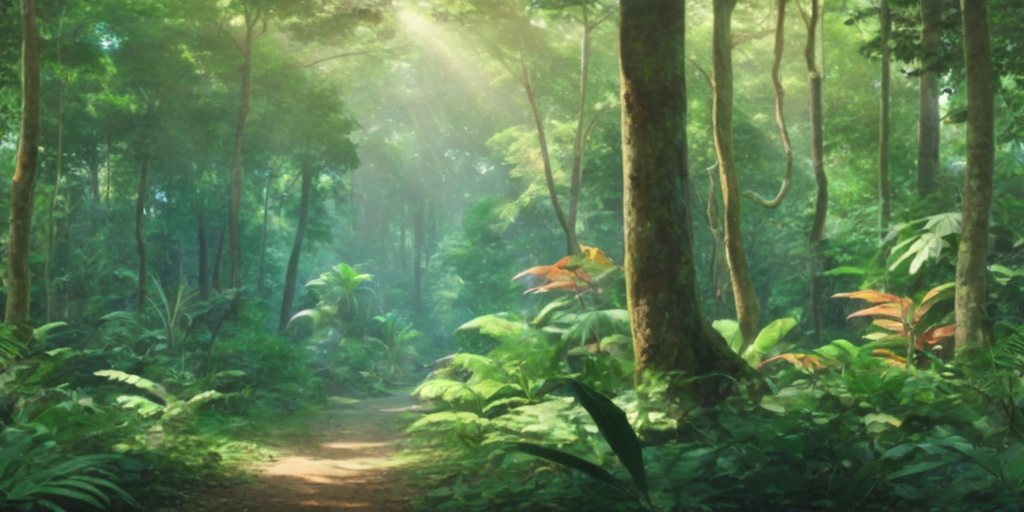

In [46]:
final_image

In [47]:
del pipe
import gc     # garbage collect library
gc.collect()
torch.cuda.empty_cache()

### Part-2: Controlnet based Depth conditioning

In [48]:
import torch
from torch import Tensor, Optional
from torch.nn import functional as F
from torch.nn.modules.utils import _pair
from huggingface_hub import hf_hub_download
import numpy as np
from PIL import Image
import diffusers
from diffusers.utils import load_image
from diffusers import DiffusionPipeline, ControlNetModel, StableDiffusionXLControlNetPipeline, AutoencoderKL
from cog_sdxl.dataset_and_utils import TokenEmbeddingsHandler

# Define asymmetric convolution function for model customization
def asymmetricConv2DConvForward(self, input: Tensor, weight: Tensor, bias: Optional[Tensor]):
    self.paddingX = (self._reversed_padding_repeated_twice[0], self._reversed_padding_repeated_twice[1], 0, 0)
    self.paddingY = (0, 0, self._reversed_padding_repeated_twice[2], self._reversed_padding_repeated_twice[3])
    working = F.pad(input, self.paddingX, mode='circular')
    working = F.pad(working, self.paddingY, mode='constant')
    return F.conv2d(working, weight, bias, self.stride, _pair(0), self.dilation, self.groups)


# Load ControlNet and Stable Diffusion XL pipeline with optimizations
controlnet = ControlNetModel.from_pretrained(
    "diffusers/controlnet-depth-sdxl-1.0-mid",
    variant="fp16",
    use_safetensors=True,
    torch_dtype=torch.float16,
).to("cuda")
pipe = StableDiffusionXLControlNetPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    controlnet=controlnet,
    variant="fp16",
    use_safetensors=True,
    torch_dtype=torch.float16,
).to("cuda")

# Disable tiling and modify convolution layers for potential efficiency gains
pipe.vae.use_tiling = False
targets = [pipe.vae, pipe.text_encoder, pipe.unet]
conv_layers = []
for target in targets:
    for module in target.modules():
        if isinstance(module, torch.nn.Conv2d):
            conv_layers.append(module)
for cl in conv_layers:
    if isinstance(cl, diffusers.models.lora.LoRACompatibleConv) and cl.lora_layer is None:
        cl.lora_layer = lambda *x: 0  # Initialize placeholder LoRA layer if needed
    cl._conv_forward = asymmetricConv2DConvForward.__get__(cl, torch.nn.Conv2d)  # Replace forward method

# Load LoRA weights for enhanced capabilities
pipe.load_lora_weights("jbilcke-hf/sdxl-panorama", weight_name="lora.safetensors")

# Prepare text encoders and tokenizers for embedding handling
text_encoders = [pipe.text_encoder, pipe.text_encoder_2]
tokenizers = [pipe.tokenizer, pipe.tokenizer_2]

# Download and load token embeddings
embedding_path = hf_hub_download(
    repo_id="jbilcke-hf/sdxl-panorama", filename="embeddings.pti", repo_type="model"
)
embhandler = TokenEmbeddingsHandler(text_encoders, tokenizers)
embhandler.load_embeddings(embedding_path)

# Generate image with specified dimensions, prompt, and depth conditioning
prompt = "animated, tropical forest in anime world"
image = load_image("/content/pano_depth.png")  # Load depth image
controlnet_conditioning_scale = 0.5  # Recommended for good generalization
images = pipe(
    prompt,
    image=image,
    controlnet_conditioning_scale=controlnet_conditioning_scale,
    cross_attention_kwargs={"scale": 0.8},
).images

# Access the generated image
final_image = images[0]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

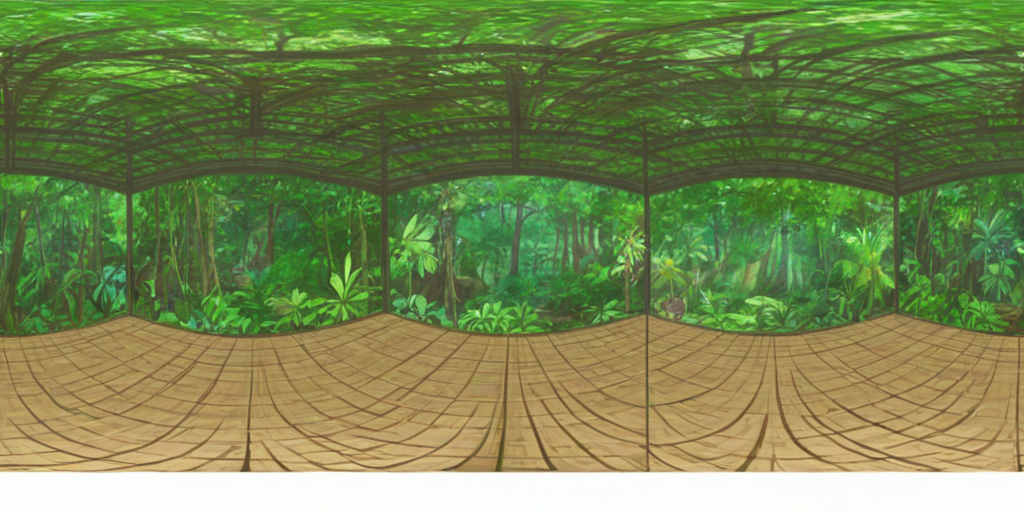

In [49]:
final_image